In [2]:
!pip install -q xgboost

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
import zipfile
import os

zip_file_path = '/content/archive (17).zip'
extracted_file_name = 'train_dataset.csv'
extracted_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(extracted_file_name, extracted_path)

print(f"Extracted {extracted_file_name} to {extracted_path}")

Extracted train_dataset.csv to /content/


In [8]:
import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_csv('/content/train_dataset.csv')

# Display the first few rows to confirm it loaded correctly
display(df.head())

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,department_finishing,department_finishing,department_sweing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity
0,9,0.75,3.94,NaN,960,0,0.0,0,0,8.0,...,1,0,0,0,0,0,0,0,1,0.755167
1,7,0.65,30.10,909.0,7080,0,0.0,0,1,59.0,...,0,0,1,0,0,0,1,0,0,0.535678
2,3,0.80,4.15,NaN,1440,0,0.0,0,0,7.0,...,0,1,0,0,0,0,0,0,1,0.820833
3,1,0.65,22.53,762.0,5040,0,0.0,0,1,42.0,...,0,0,1,0,0,0,0,0,1,0.581131
4,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,...,0,0,1,1,0,0,0,0,0,0.790003


In [9]:
# Handle missing values by filling with the mean
df['wip'] = df['wip'].fillna(df['wip'].mean())
# Assuming the first 'department_finishing' is the one to keep
df = df.loc[:,~df.columns.duplicated()].copy()

# Define features (X) and target (y)
# Assuming 'actual_productivity' is the target variable
X = df.drop('actual_productivity', axis=1)
y = df['actual_productivity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

print("\n📊 XGBOOST RESULTS:")
print("R² Score:", r2_score(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


📊 XGBOOST RESULTS:
R² Score: 0.31021968481457474
RMSE: 0.15135243157249534


In [12]:
# Train a RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Scale the entire feature set X
X_scaled = scaler.transform(X)

# Make predictions using the trained models
y_pred_rf = rf.predict(X_scaled)
y_pred_xgb = xgb.predict(X_scaled)

# Add predicted scores to the DataFrame
df['Predicted_Score_RF'] = y_pred_rf
df['Predicted_Score_XGB'] = y_pred_xgb

# Define a simple classification function (you might need to adjust this based on your criteria)
def classify_score(score):
    if score >= 0.8:
        return 'High'
    elif score >= 0.6:
        return 'Medium'
    else:
        return 'Low'

# Create category columns
df['Category_RF'] = df['Predicted_Score_RF'].apply(classify_score)
df['Category_XGB'] = df['Predicted_Score_XGB'].apply(classify_score)

# Add an 'Intern_ID' column if it doesn't exist (using index as a placeholder)
if 'Intern_ID' not in df.columns:
    df['Intern_ID'] = df.index

/tmp/ipython-input-14-1468455620.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category_RF', palette='Blues', ax=ax[0])
/tmp/ipython-input-14-1468455620.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category_XGB', palette='Greens', ax=ax[1])


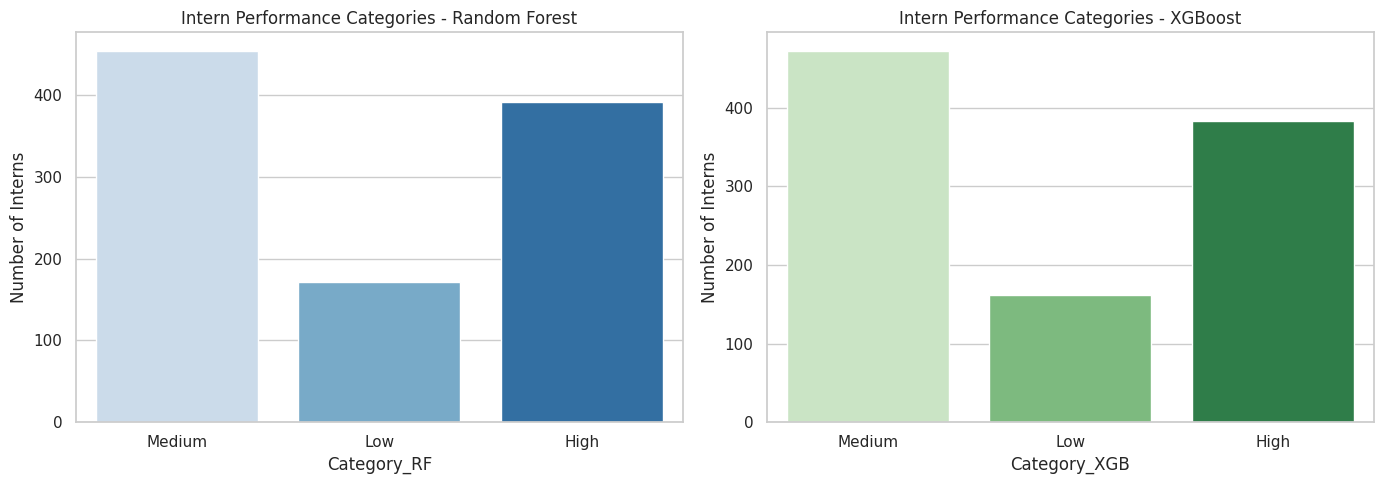

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Bar plot: Count of interns in each category
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='Category_RF', palette='Blues', ax=ax[0])
ax[0].set_title('Intern Performance Categories - Random Forest')
ax[0].set_ylabel('Number of Interns')

sns.countplot(data=df, x='Category_XGB', palette='Greens', ax=ax[1])
ax[1].set_title('Intern Performance Categories - XGBoost')
ax[1].set_ylabel('Number of Interns')

plt.tight_layout()
plt.show()
